## Importing Data & Libraries

In [1]:
import pandas as pd
import regex as re
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Reads all csv's in granular folder
df = pd.DataFrame()
for file in os.listdir('../data/exports/granular/'):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'):
        df = pd.concat([df, pd.read_csv('../data/exports/granular/'+filename)])
    else:
        pass

In [3]:
## Renames addresses where the country is in its full name rather than the 3 letter code
df['end_address'] = [address.replace('United States', 'USA') for address in df['end_address']]
df['end_address'] = [address.replace('Canada', 'CAN') for address in df['end_address']]

In [4]:
## Creates a country column
country = []
for address in df['end_address']:
    if 'USA' in address:
        country.append('USA')
    elif 'CAN' in address:
        country.append('CAN')
    else:
        country.append('Unidentified')
df['country'] = country

In [5]:
## Drops rows where the country isn't USA or CAN
df.drop(df[((df['country'] != 'USA') & (df['country'] != 'CAN'))].index, inplace=True)

## Drops rows where there is no distance data
df.drop(df[df['duration'] == 'Failed'].index, inplace=True)

## Reset Index
df.reset_index(inplace=True, drop=True)

In [6]:
## Creates a state column
state = []
for address in df['end_address']:
    try:
         state.append(re.search('(A[KLRZ]|C[AOT]|D[CE]|FL|GA|HI|I[ADLN]|K[SY]|LA|M[ADEINOST]|N[CDEHJMVY]|O[HKR]'
                                '|P[AR]|RI|S[CD]|T[NX]|UT|V[AIT]|W[AIVY])', address).group(0))
    except:
        state.append('Unidentified')
df['state'] = state

In [7]:
## Resets duration and distance to floats
df['duration'] = df['duration'].astype('float')
df['distance'] = df['distance'].astype('float')

In [8]:
## Reset names as lower case
df['business_name'] = [biz.lower() for biz in df['business_name']]
df['target_name'] = [target.lower() for target in df['target_name']]

## Calculate Swamp Score

In [9]:
def calculate_points(df):
    for i, row in df.iterrows():
        if row['duration'] < 600:
            df.loc[i, 'proximity'] = 'close'
            df.loc[i, 'points'] = 3
        elif row['duration'] < 1200:
            df.loc[i, 'proximity'] = 'medium'
            df.loc[i, 'points'] = 2
        elif row['duration'] < 3600:
            df.loc[i, 'proximity'] = 'far'
            df.loc[i, 'points'] = 1
        else:
            df.loc[i, 'proximity'] = 'over_hour'
            df.loc[i, 'points'] = 0
    return df

In [10]:
def calculate_gradient_points(df):
    for i, row in df.iterrows():
        if row['duration'] <= 3600:
            df.loc[i, 'gradient_points'] = abs(row['duration'] - 3600)
        else:
            df.loc[i, 'gradient_points'] = 0
    return df

In [11]:
def calculate_swamp_score(df):
    iter_address = set(df['start_address'])
    swamp_df = pd.DataFrame()
    for i, i_address in enumerate(iter_address):
        swamp_df.loc[i,'start_address'] = i_address
        swamp_df.loc[i,'state'] = re.search('(A[KLRZ]|C[AOT]|D[CE]|FL|GA|HI|I[ADLN]|K[SY]|LA|M[ADEINOST]'
            '|N[CDEHJMVY]|O[HKR]|P[AR]|RI|S[CD]|T[NX]|UT|V[AIT]|W[AIVY])', i_address).group(0)
        
        
        conv_store_points = df[df['start_address'] == i_address].groupby('label').sum()['points']['conv_store']
        swamp_df.loc[i,'conv_store_points'] = conv_store_points
        
        fast_food_points = df[df['start_address'] == i_address].groupby('label').sum()['points']['fast_food_rest']
        swamp_df.loc[i,'fast_food_points'] = fast_food_points
        
        groc_store_points = df[df['start_address'] == i_address].groupby('label').sum()['points']['groc_store']
        swamp_df.loc[i,'groc_store_points'] = groc_store_points
        
        swamp_df.loc[i, 'swamp_score'] = (conv_store_points + fast_food_points) / groc_store_points
        
        
        conv_store_grad_points = df[df['start_address'] == i_address].groupby('label')\
            .sum()['gradient_points']['conv_store']
        swamp_df.loc[i,'conv_store_grad_points'] = conv_store_grad_points
        fast_food_grad_points = df[df['start_address'] == i_address].groupby('label')\
            .sum()['gradient_points']['fast_food_rest']
        swamp_df.loc[i,'fast_food_grad_points'] = fast_food_grad_points
        groc_store_grad_points = df[df['start_address'] == i_address]\
            .groupby('label').sum()['gradient_points']['groc_store']
        swamp_df.loc[i,'groc_store_grad_points'] = groc_store_points
        swamp_df.loc[i, 'grad_swamp_score'] = (conv_store_grad_points + fast_food_grad_points)\
            / groc_store_grad_points
        
    return swamp_df

In [12]:
df = calculate_points(df)
df = calculate_gradient_points(df)

In [13]:
swamp_df = calculate_swamp_score(df)

In [14]:
swamp_df

,start_address,state,conv_store_points,fast_food_points,groc_store_points,swamp_score,conv_store_grad_points,fast_food_grad_points,groc_store_grad_points,grad_swamp_score
0,482-S-Lincoln-St-Denver-CO,CO,164.0,1519.0,406.0,4.145320,213879.0,2280075.0,406.0,4.511592
1,402-Arrawanna-St-Colorado-Springs-CO,CO,330.0,745.0,297.0,3.619529,402587.0,987293.0,297.0,3.530643
2,3481-Thornbury-Ln-Bonita-Springs-FL,FL,132.0,400.0,177.0,3.005650,193326.0,569328.0,177.0,3.204981
3,167-Cedar-Lane-Ossining-NY,NY,78.0,807.0,182.0,4.862637,85965.0,979484.0,182.0,5.182800
4,1850-Chestnut-Place-Denver-CO-80205,CO,454.0,1657.0,560.0,3.769643,600558.0,2357327.0,560.0,3.803659
5,49-South-St-Natick-MA,MA,170.0,645.0,246.0,3.313008,240424.0,898481.0,246.0,3.427226
6,128-Edmunds-Road-Wellesley-MA,MA,206.0,790.0,325.0,3.064615,329457.0,1216392.0,325.0,3.233033
7,2301-Vanderbilt-Place-Nashville-TN-37235,TN,165.0,935.0,394.0,2.791878,242044.0,1399125.0,394.0,2.780752
8,351-California-St-Ste-450-San-Francisco-CA,CA,103.0,1238.0,354.0,3.788136,167376.0,1687314.0,354.0,3.808821
9,803-Sheep-Farm-Rd-Weybridge-VT,VT,6.0,69.0,54.0,1.388889,1485.0,60747.0,54.0,1.183050


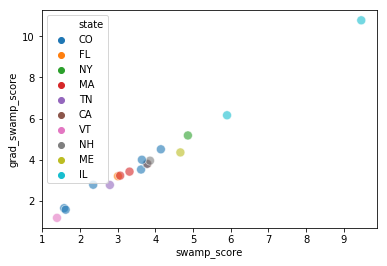

In [15]:
sns.scatterplot(swamp_df['swamp_score'],swamp_df['grad_swamp_score'],
                hue = swamp_df['state'], alpha=.6, s=80);

In [16]:
swamp_df[['start_address','swamp_score','grad_swamp_score']]

,start_address,swamp_score,grad_swamp_score
0,482-S-Lincoln-St-Denver-CO,4.145320,4.511592
1,402-Arrawanna-St-Colorado-Springs-CO,3.619529,3.530643
2,3481-Thornbury-Ln-Bonita-Springs-FL,3.005650,3.204981
3,167-Cedar-Lane-Ossining-NY,4.862637,5.182800
4,1850-Chestnut-Place-Denver-CO-80205,3.769643,3.803659
5,49-South-St-Natick-MA,3.313008,3.427226
6,128-Edmunds-Road-Wellesley-MA,3.064615,3.233033
7,2301-Vanderbilt-Place-Nashville-TN-37235,2.791878,2.780752
8,351-California-St-Ste-450-San-Francisco-CA,3.788136,3.808821
9,803-Sheep-Farm-Rd-Weybridge-VT,1.388889,1.183050


## Swamp Scores with Filtered Data

In [17]:
df_clean = df

In [18]:
df_clean['business_name'].replace({
    'subway restaurants' : 'subway',
    "dunkin'" : "dunkin donuts",
    "pizza hut express" : "pizza hut",
    "pizza hut®" : "pizza hut",
    "domino's pizza" : "domino's",
    "dominos" : "domino's",
    "baskin robbins" : "baskin-robbins",
    "baskin-robbins kingston" : "baskin-robbins",
    "dairy queen (treat)" : "dairy queen",
    "dairy queen (treat only)" : "dairy queen",
    "dairy queen store" : "dairy queen",
    "dairy queen ltd brazier" : "dairy queen",
    "dairy queen (limited brazier)" : "dairy queen",
    "dairy queen grill & chill" : "dairy queen",
    "dairy queen grill & chill restaurant" : "dairy queen",
    "dairy queen / orange julius" : "dairy queen",
    "dairy queen / orange julius treat center" : "dairy queen",
    "dairy queen/orange julius treat ctr" : "dairy queen",
    "dq / orange julius" : "dairy queen",
    "little caesars pizza" : "little caesars",
    "little caesers" : "little caesars",
    "cosentino's price chopper" : "price chopper",
    "price chopper pharmacy" : "price chopper",
    "wegman's nursery" : "wegmans",
    "wegmans natick" : "wegmans",
    "hannaford supermarket" : "hannaford",
    "hannaford pharmacy" : "hannaford",
    "chipotle mexican grill" : "chipotle",
    "chick-fil-a broadway & dartmouth" : "chick-fil-a",
    "jersey mike's" : "jersey mike's subs",
    "jersey mike’s subs" : "jersey mike's subs",
    "7 eleven" : '7-eleven',
    "casey's general store" :  "casey’s general store",
    "express mart convenience store" : "express mart",
    "express mart inc" : "express mart",
    "stripes" : "stripes convenience",
    "stripes convenience store" : "stripes convenience",
    "stripes gas station" : "stripes convenience",
    "stripes 7075" : "stripes convenience",
    "safeway bakery" : "safeway",
    "safeway pharmacy" : "safeway",
    "safeway dawson road" : "safeway",
    "safeway liquor" : "safeway",
    "safeway community markets" : "safeway",
    "king soopers pharmacy" : "king soopers",
    "king soopers marketplace" : "king soopers",
    "whole foods market" : "whole foods",
    "whole foods market 365": "whole foods",
    "whole foods - 788 harrison street" : "whole foods",
    "wholefood" : "whole foods",
    "limon stop & shop supermarket" : "stop & shop",
    "flagler stop & shop supermarket" : "stop & shop",
    "stop & shop pharmacy" : "stop & shop",
    "stop n shop" : "stop & shop",
    "super stop & shop" : "stop & shop",
    "stop'n shop" : "stop & shop",
    "stop & shop supermarket" : "stop & shop",
    "stop & shop market" : "stop & shop",
    "stop - n - shop" : "stop & shop",
    "hunt brother's pizza" : "hunt brothers pizza",
    "hunt brothers pizza - n union st" : "hunt brothers pizza",
    "hunt brothers pizaa" : "hunt brothers pizza",
    "popeyes® louisiana kitchen" : "popeyes louisiana kitchen",
    "jimmy john’s" : "jimmy john's",
    "starbucks reserve" : "starbucks",
    "albertsons market" : "albertsons",
    "pete's fresh market" : "pete’s fresh market",
    "kroger deli" : "kroger",
    "kroger bakery" : "kroger",
    "public" : "publix"
}, inplace=True)

In [19]:
for i, row in df_clean.iterrows():
    if "publix super market at" in row['business_name']:
        df_clean.loc[i, 'business_name'] = 'publix'

In [20]:
df_clean[(df_clean['state'] == 'FL') & (df_clean['business_name'] != df_clean['target_name'])\
         & (df['label'] == 'groc_store')].loc[3247:,:]

,business_name,target_name,label,business_types,google_place_id,rating,user_ratings_total,end_address,latitude,longitude,pull_date,duration,distance,start_address,country,state,proximity,points,gradient_points
4833,starbucks,safeway,groc_store,"cafe, store, point_of_interest, food, establis...",ChIJNe88_LsZ24gRpdvPLw4gcy8,4.3,236,"27250 Bay Landing Dr, Bonita Springs, FL 34135...",26.343885,-81.806585,2019-05-15,435.0,2749.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,close,3.0,3165.0
4834,safe way traction,safeway,groc_store,"point_of_interest, establishment",ChIJf7eX5F1aDogRj5fTL3Vr1Oo,0,0,"2271 Bruner Ln Unit 6, Fort Myers, FL 33912, USA",26.533488,-81.858250,2019-05-15,1792.0,26341.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1808.0
4840,soldae natural health,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJu_rGHLsZ24gROkLpmO7Bx4o,0,0,"23680 Walden Unit 303, Riverview Center Blvd, ...",26.340570,-81.808529,2019-05-15,367.0,2956.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,close,3.0,3233.0
4841,mother earth natural foods,natural grocers,groc_store,"grocery_or_supermarket, store, health, point_o...",ChIJRVnBUdg-24gRmBM-z9Z8IyY,4.1,12,"15271-7 McGregor Boulevard, Fort Myers, FL 339...",26.520198,-81.939487,2019-05-15,2181.0,31804.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1419.0
4842,organic food brokers,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJbfqUCITua4cRiXEoyabcXf0,0,0,"28411 Race Track Rd, Bonita Springs, FL 34135,...",26.322830,-81.774168,2019-05-15,764.0,7945.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,medium,2.0,2836.0
4843,mother earth natural foods,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJKTUhKTlA24gRqVw5nUSEFOY,4.5,19,"4600 Summerlin Rd C10, Fort Myers, FL 33919, USA",26.595218,-81.885248,2019-05-15,2396.0,35032.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1204.0
4844,mother earth natural foods,natural grocers,groc_store,"grocery_or_supermarket, store, health, point_o...",ChIJCZ-yQ44V24gRHbcI791gF04,4.5,8,"16520 S Tamiami Trail, Fort Myers, FL 33908, USA",26.500785,-81.857544,2019-05-15,1471.0,21014.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,2129.0
4845,vr laboratories llc,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJ1XBNHKcZ24gRapBjyQViF2E,0,0,"3301 Bonita Beach Rd SW # 315, Bonita Springs,...",26.329824,-81.807927,2019-05-15,510.0,4438.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,close,3.0,3090.0
4846,organic farm market,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJe7UNb-jh2ogRvEwEr603G-4,5,4,"2132 Tamiami Trail N, Naples, FL 34103, USA",26.172742,-81.798624,2019-05-15,1692.0,21625.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1908.0
4847,ada's natural market,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJMcFg-SNA24gRn4bupwJxCmY,4.1,309,"7070 College Pkwy, Fort Myers, FL 33907, USA",26.557489,-81.873368,2019-05-15,1939.0,27615.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1661.0


In [21]:
df_clean[(df_clean['business_name'] != df_clean['target_name']) & (df_clean['business_name'] != 'dunkin donuts')\
        & (df_clean['state'] == 'FL')]\
    .groupby('business_name').count().sort_values('target_name', ascending=False)

,target_name,label,business_types,google_place_id,rating,user_ratings_total,end_address,latitude,longitude,pull_date,duration,distance,start_address,country,state,proximity,points,gradient_points
business_name,,,,,,,,,,,,,,,,,,
bojangles' famous chicken 'n biscuits,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
publix super market on bayshore,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
atm (cumberland farms),8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
publix super market market square,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
"fast stop, hunt brothers pizza, laundromat",5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
mother earth natural foods,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
atm (fifth third bank),4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
the fresh market,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
kangaroo express,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [22]:
df_clean['target_name'].replace({
    "traders joe's" : "trader joe's",
    "bojangles' famous chicken 'n biscuit'" : "bojangles' famous chicken 'n biscuits"
}, inplace=True)

In [23]:
df_clean = df.drop(df_clean[(df_clean['business_name'] != df_clean['target_name'])\
                            & (df_clean['business_name'] != 'dunkin donuts')].index)
df_clean.reset_index(inplace=True, drop=True)

In [24]:
df_clean = calculate_points(df_clean)
df_clean = calculate_gradient_points(df_clean)

In [25]:
swamp_df_clean = calculate_swamp_score(df_clean)

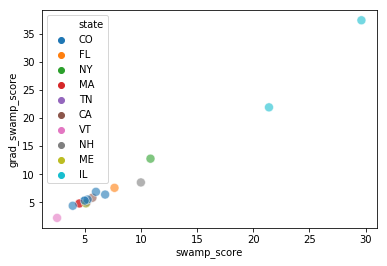

In [26]:
sns.scatterplot(swamp_df_clean['swamp_score'],swamp_df_clean['grad_swamp_score'],
                hue = swamp_df_clean['state'], alpha=.6, s=80);

In [27]:
swamp_df_clean[['start_address','swamp_score','grad_swamp_score']]

,start_address,swamp_score,grad_swamp_score
0,482-S-Lincoln-St-Denver-CO,4.933754,5.260530
1,402-Arrawanna-St-Colorado-Springs-CO,6.818182,6.393735
2,3481-Thornbury-Ln-Bonita-Springs-FL,7.650794,7.583805
3,167-Cedar-Lane-Ossining-NY,10.855263,12.765856
4,1850-Chestnut-Place-Denver-CO-80205,5.076923,4.899656
5,49-South-St-Natick-MA,4.526946,4.810532
6,128-Edmunds-Road-Wellesley-MA,4.525000,4.807632
7,2301-Vanderbilt-Place-Nashville-TN-37235,5.183908,5.009728
8,351-California-St-Ste-450-San-Francisco-CA,5.686170,5.828229
9,803-Sheep-Farm-Rd-Weybridge-VT,2.541667,2.242114


## Combining Swamp Score tables

In [28]:
combined_swamp_df = pd.merge(swamp_df, swamp_df_clean, how='inner', on='start_address', suffixes=('', '_clean'))

In [29]:
combined_swamp_df[['start_address','state','swamp_score','grad_swamp_score','swamp_score_clean',
    'grad_swamp_score_clean',]].sort_values('state').sort_values('grad_swamp_score_clean', ascending=False)

,start_address,state,swamp_score,grad_swamp_score,swamp_score_clean,grad_swamp_score_clean
16,352-arquilla-ct-bloomingdale-IL,IL,9.463277,10.771504,29.629630,37.358385
17,1931-N-Fremont-St-Chicago-IL-60614,IL,5.901274,6.162289,21.402597,21.887584
3,167-Cedar-Lane-Ossining-NY,NY,4.862637,5.182800,10.855263,12.765856
10,86-Jackson-Highlands-Rd-Jackson-NH,NH,3.857143,3.957989,10.000000,8.543946
2,3481-Thornbury-Ln-Bonita-Springs-FL,FL,3.005650,3.204981,7.650794,7.583805
13,501-North-Park-Avenue-Breckenridge-CO,CO,1.578125,1.654068,6.000000,6.875926
1,402-Arrawanna-St-Colorado-Springs-CO,CO,3.619529,3.530643,6.818182,6.393735
8,351-California-St-Ste-450-San-Francisco-CA,CA,3.788136,3.808821,5.686170,5.828229
12,410-Delaware-St-Denver-CO,CO,3.641791,4.002861,5.261745,5.512087
15,10-Club-Cir-Aspen-CO,CO,1.619048,1.579278,5.000000,5.317630


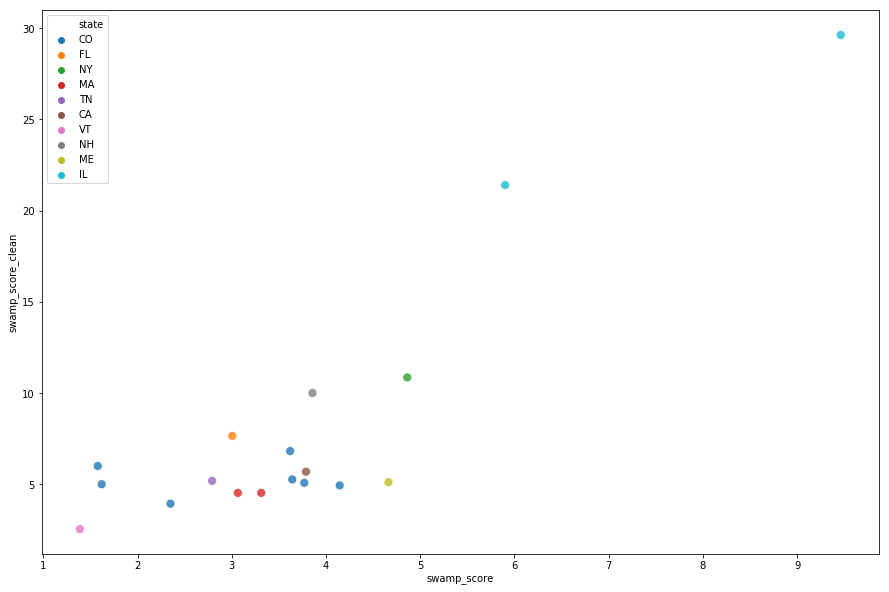

In [58]:
plt.figure(figsize=(15,10))
sns.scatterplot(combined_swamp_df['swamp_score'],combined_swamp_df['swamp_score_clean'],
                hue = combined_swamp_df['state'], alpha=.8, s=80);

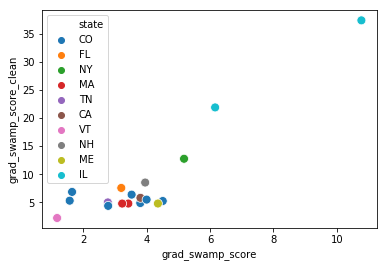

In [31]:
sns.scatterplot(combined_swamp_df['grad_swamp_score'],combined_swamp_df['grad_swamp_score_clean'],
                hue = combined_swamp_df['state'], alpha=1, s=80);

## Data Exports

In [32]:
## All of the data collected for all of the data pulls
df.to_csv('../data/exports/granular_master.csv', index=False)

## Cleaned data collected for all of the pulls
df_clean.to_csv('../data/exports/granular_master_clean.csv', index=False)

## Only the buisnesses pulled
df_business_master = df.drop_duplicates(subset='end_address', keep='last')
df_business_master = df_business_master.drop(columns=['start_address', 'duration', 'distance',
                                 'proximity', 'points', 'gradient_points'])
df_business_master.reset_index(inplace=True, drop=True)
df_business_master.to_csv('../data/exports/business_master.csv', index=False)

## Swamp score data
combined_swamp_df.to_csv('../data/exports/combined_swamp.csv', index=False)